In [ ]:
%load_ext autoreload
%autoreload 2

In [57]:
import sys
sys.path.append('..')

import warnings
warnings.filterwarnings("ignore")

import pymc3 as pm
from tqdm import tqdm
from sklearn.metrics import *
import numpy as np
import rasterio as rio
from rasterstats import zonal_stats

from src.utils import *
from src.params import *
tqdm.pandas()

%matplotlib inline

# Load Model

In [ ]:
df, basin_idx, basins, coords = read_data(file_dir='../data/hierarchical_septics_v4.csv',
        cols=['ppt_2021', 'hydraulic_c','median_hse', 'dem'], is_balanced=True)

In [ ]:
rs = 100
tune = 1000

In [ ]:
# Modeling (full)
with pm.Model(coords=coords) as model:
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx, dims='septic')
    ppt_d = pm.Data('ppt_d', df.ppt_2021_norm.values, dims='septic')
    hydr_d = pm.Data('hydr_d', df.hydraulic_c_norm.values, dims='septic')
    hse_d = pm.Data('hse_d', df.median_hse_norm.values, dims='septic')
    dem_d = pm.Data('dem_d', df.dem_norm.values, dims='septic')

    # global model parameters
    ppt_mu = pm.Normal('ppt_mu', mu=0, sigma=10)
    ppt_sig = pm.HalfNormal('ppt_sig', sigma=10)
    hydr_mu = pm.Normal('hydr_mu', mu=0, sigma=10)
    hydr_sig = pm.HalfNormal('hydr_sig', sigma=10)
    hse_sig = pm.HalfNormal('hse_sig', sigma=10)
    dem_beta = pm.HalfNormal('dem_beta', sigma=10)
    mu_c = pm.Normal('mu_c', mu=0, sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # septic-specific model parameters
    ppt = pm.Normal('ppt', mu=ppt_mu, sigma=ppt_sig, dims='basin')
    hydr = pm.Normal('hydr', mu=hydr_mu, sigma=hydr_sig, dims='basin')
    hse = pm.Normal('hse', mu=0, sigma=hse_sig, dims='basin')
    dem = pm.Exponential('dem', lam=dem_beta, dims='basin')
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c, dims='basin')
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c[basin] 
                                    + ppt[basin] * ppt_d
                                    + hydr[basin] * hydr_d
                                    + hse[basin] * hse_d
                                    + dem[basin] * dem_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(100, tune=tune, cores=3, return_inferencedata=True, target_accept=0.99, random_seed=rs)

In [262]:
# Get all learned parameters
hier_post = trace.posterior.stack(chain_draw=("chain", "draw"))

learned_params = dict()
learned_params.update({
    'c': hier_post['c'].median().item(),
    'ppt': hier_post['ppt'].median().item(),
    'hydr': hier_post['hydr'].median().item(),
    'hse': hier_post['hse'].median().item(),
    'dem': hier_post['dem'].median().item()
})

learned_params

{'c': 11.331642577127145,
 'ppt': -0.8115328521205818,
 'hydr': -0.1770402479132223,
 'hse': -0.0612081866840997,
 'dem': 5.0302202074625395}

# Inference

Helper functions and constants

In [263]:
learned_params = {'c': 11.331642577127145,
 'ppt': -0.8115328521205818,
 'hydr': -0.1770402479132223,
 'hse': -0.0612081866840997,
 'dem': 5.0302202074625395}

def get_inference_data(indep_srcs, state_id):
    state_id = str(state_id)

    # Get boundary
    bdry = gpd.read_file(indep_srcs['bdry'])
    state_bdry = bdry[bdry['STATEFP'] == state_id].reset_index(drop=True)
    outer_bdry = state_bdry.dissolve()
    del indep_srcs['bdry']

    # Get raster mean value for each county
    for indep_var in indep_srcs.keys():
        filename = indep_srcs[indep_var]
        with rio.open(filename) as src:
            affine = src.transform
            array = src.read(1)
            zones = pd.DataFrame(zonal_stats(state_bdry, array, affine=affine, stats='mean'))
        
        var_name = f'{indep_var}_mean'
        state_bdry[var_name] = zones['mean']
        state_bdry[var_name] = (state_bdry[var_name] - state_bdry[var_name].mean()) / state_bdry[var_name].std() # z-normalize

    # Get housing value
    acs_dict = {
        'type': 'acs5',
        'year': 2019,
        'state': state_id,
        'code': 'B25077_001E',
        'col_name': 'median_hse'
    }

    acs = (censusdata.download(
        acs_dict['type'],
        acs_dict['year'], 
        censusdata.censusgeo([('state', acs_dict['state']), ('county', '*')]), [acs_dict['code']]
    ).reset_index().rename(columns={acs_dict['code']: 'median_hse'}))

    for i, row in acs.iterrows():
        county = (str(row['index'])
                    .split(',')[0]
                    .split('County')[0]
                    .strip())

        acs.loc[i, 'County'] = county
    
    for i, row in state_bdry.iterrows():
        hse_mean = acs[acs['County'] == row['NAME']]['median_hse'].item()
        state_bdry.loc[i, 'hse_mean'] = hse_mean
        
    state_bdry['hse_mean'] = (state_bdry['hse_mean'] - state_bdry['hse_mean'].mean()) / state_bdry['hse_mean'].std() # z-normalize

    return state_bdry

# Compute probability of failure 
def compute_risk_probability(gdf, learned_params, sampling_sz=500):
    for i, row in gdf.iterrows():
        failure_theta = pm.math.sigmoid(learned_params['c']
                                            + learned_params['ppt'] * row['ppt_mean']
                                            + learned_params['hydr'] * row['soil_mean']
                                            + learned_params['hse'] * row['hse_mean']
                                            + learned_params['dem'] * row['dem_mean']
                                        )

        failures = pm.Bernoulli.dist(failure_theta)
        risk = failures.random(size=sampling_sz)
        risk = 1 - risk # recall failure is assigned the value of 0
        risk_mean = risk.mean()
        risk_std = risk.std()
        gdf.loc[i, 'risk_mean'] = risk_mean
        gdf.loc[i, 'risk_std'] = risk_std

    gdf['risk_mean'] = (gdf['risk_mean'] - gdf['risk_mean'].min()) / (gdf['risk_mean'].max() - gdf['risk_mean'].min())
    gdf['risk_std'] = (gdf['risk_std'] - gdf['risk_std'].min()) / (gdf['risk_std'].max() - gdf['risk_std'].min())
    
    return gdf

## Georgia

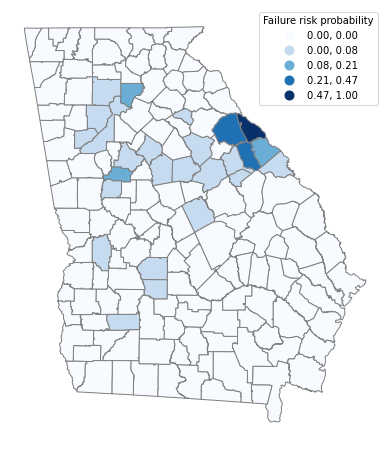

In [264]:
state_id = '13' # Georgia
indep_srcs = {
    'bdry': '../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp',
    'ppt': '../../Data/precipitation/annual_max_2021.tif',
    'soil': '../../Data/soil/mosaic/GA.tif',
    'dem': '../../Data/precipitation/annual_max_2021.tif',
}

gdf = get_inference_data(indep_srcs, state_id=state_id)
gdf = compute_risk_probability(gdf, learned_params)

# Plot
f, ax = plt.subplots(figsize=(8,8))
gdf.plot(
    column='risk_mean', 
    edgecolor='grey', 
    cmap='Blues', 
    scheme='natural_breaks', 
    ax=ax,
    legend=True, legend_kwds={'title': 'Failure risk probability'})

ax.axis('off')
f.savefig('../docs/GA_risk_map.pdf', dpi=300)

## Florida

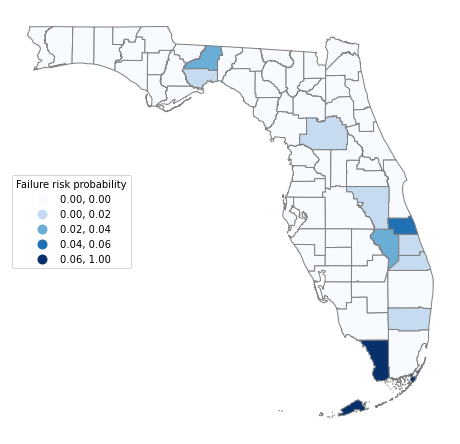

In [265]:
state_id = '12' # Florida
indep_srcs = {
    'bdry': '../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp',
    'ppt': '../../Data/precipitation/annual_max_2021.tif',
    'soil': '../../Data/soil/mosaic/FL.tif',
    'dem': '../../Data/precipitation/annual_max_2021.tif',
}

gdf = get_inference_data(indep_srcs, state_id=state_id)
gdf = compute_risk_probability(gdf, learned_params)

# Plot
f, ax = plt.subplots(figsize=(8,8))
gdf.plot(
    column='risk_mean', 
    edgecolor='grey', 
    cmap='Blues', 
    scheme='natural_breaks', 
    ax=ax,
    legend=True, legend_kwds={'title': 'Failure risk probability', 'loc': 'center left'})

ax.axis('off')
f.savefig('../docs/FL_risk_map.pdf', dpi=300)

## Alabama

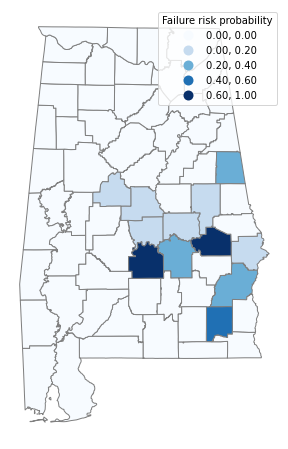

In [266]:
state_id = '01' # AL
indep_srcs = {
    'bdry': '../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp',
    'ppt': '../../Data/precipitation/annual_max_2021.tif',
    'soil': '../../Data/soil/mosaic/AL.tif',
    'dem': '../../Data/precipitation/annual_max_2021.tif',
}

gdf = get_inference_data(indep_srcs, state_id=state_id)
gdf = compute_risk_probability(gdf, learned_params)

# Plot
f, ax = plt.subplots(figsize=(8,8))
gdf.plot(
    column='risk_mean', 
    edgecolor='grey', 
    cmap='Blues', 
    scheme='natural_breaks', 
    ax=ax,
    legend=True, legend_kwds={'title': 'Failure risk probability', 'loc': 'best'})

ax.axis('off')
f.savefig('../docs/AL_risk_map.pdf', dpi=300)